In [1]:
import torch
# from torch.utils.data import DataLoader, Dataset
# from skmultilearn.model_selection import iterative_train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
# import pandas as pd
import pickle
# from sklearn.model_selection import train_test_split
import seaborn as sns
# from skmultilearn.model_selection import iterative_train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [2]:
with open('d:\\year 4\\semester 1\\BT\\BT 4033\\prediction\\labels\\bp_terms_class_order.pkl', 'rb') as f:
    go_terms_order = pickle.load(f)

In [19]:
with open('d:\\year 4\\semester 1\\BT\\BT 4033\\prediction\\datasets\\bp_dataset.pkl', 'rb') as f:
    prior_dataset = pickle.load(f)

In [20]:
def calculate_accuracy(predictions, labels, threshold=0.5):
    """
    Calculate multi-label accuracy.
    - predictions: Model outputs (probabilities after sigmoid).
    - labels: Ground truth labels.
    - threshold: Threshold to convert probabilities to binary labels (default 0.5).
    """
    # # Apply threshold to convert probabilities to binary predictions
    predicted_labels = (predictions > threshold).astype(int)    
   
    # Iterate over each class (column)
    num_classes = labels.shape[1]
    TP, FP, TN, FN = 0, 0, 0, 0

    for class_idx in range(num_classes):
        y_true = labels[:, class_idx]
        y_pred = predicted_labels[:, class_idx]
        
        # Calculate TP, TN, FP, FN
        tp = np.sum((y_true == 1) & (y_pred == 1), axis=0)
        tn = np.sum((y_true == 0) & (y_pred == 0), axis=0)
        fp = np.sum((y_true == 0) & (y_pred == 1), axis=0)
        fn = np.sum((y_true == 1) & (y_pred == 0), axis=0)
        
        TP += tp
        FP += fp
        TN += tn
        FN += fn
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return accuracy

In [21]:
def train_model(model, inputs, labels, criterion, optimizer):
    model.train()  # Set model to training mode

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute loss
    loss = criterion(outputs, labels)
    # train_losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    probabilities = outputs.sigmoid()  # Convert logits to probabilities
    accuracy = calculate_accuracy(probabilities.detach().numpy(), labels.detach().numpy())
    # train_accuracies.append(accuracy)
    # Return the loss
    return loss.item(), accuracy 


# Testing function without batching
def test_model(model, inputs, labels, criterion):
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for testing
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        # test_losses.append(loss.item())

    # Apply sigmoid to outputs for multi-label probabilities
    probabilities = outputs.sigmoid()
    accuracy = calculate_accuracy(probabilities.detach().numpy(), labels.detach().numpy())
    # test_accuracies.append(accuracy)

    # Return the loss and predictions
    return loss.item(), accuracy

In [22]:
# Define the model
class BP_PredictorModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(BP_PredictorModel, self).__init__()
        self.input_layer = nn.Linear(input_size, input_size)
        self.middle_layer = nn.Linear(input_size, input_size)
        self.output_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.input_layer(x).relu()
        x = self.middle_layer(x).relu()
        
        x = self.output_layer(x)
        return x

In [28]:
inputs = np.array([vect['vect'] for vect in prior_dataset.values()])
outputs = np.array([vect['enc_label'] for vect in prior_dataset.values()])

In [29]:
outputs.shape

(17338, 296)

In [30]:
inputs.shape

(17338, 225)

In [31]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=4, shuffle=True, random_state=0)
# # for i, (train_index, test_index) in enumerate(skf.split(inputs, outputs)):
# #     print(f"Fold {i}:")
# #     print(f"  Train: index={train_index}")
# #     print(f"  Test:  index={test_index}")

# # Iterate through each split
# for fold, (train_index, test_index) in enumerate(kf.split(inputs, outputs)):
#     print(f"Fold {fold + 1}")
    
#     # Split data into training and testing sets
#     X_train, X_test = inputs[train_index], inputs[test_index]
#     y_train, y_test = outputs[train_index], outputs[test_index]
#     train_class_counts = np.sum(y_train == 1, axis=0)
#     classes = torch.arange(len(train_class_counts))  # Class indices
#     plt.bar(classes, train_class_counts)
#     plt.xlabel('Classes')
#     plt.ylabel('Frequency')
#     plt.title('Training Class Distribution')
#     plt.show()

In [32]:
msss = MultilabelStratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
# for train_index, test_index in msss.split(inputs, outputs):
#    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [    0     1     3 ... 17334 17336 17337] TEST: [    2     6    13 ... 17324 17330 17335]
Epoch 1/100, Train Loss: 1.3737, Train Accuracy: 0.4737, Test Loss: 1.3584, Test Accuracy: 0.5863
Epoch 2/100, Train Loss: 1.3563, Train Accuracy: 0.5867, Test Loss: 1.3047, Test Accuracy: 0.6621
Epoch 3/100, Train Loss: 1.3025, Train Accuracy: 0.6622, Test Loss: 1.1970, Test Accuracy: 0.7022
Epoch 4/100, Train Loss: 1.1946, Train Accuracy: 0.7020, Test Loss: 1.0396, Test Accuracy: 0.7276
Epoch 5/100, Train Loss: 1.0376, Train Accuracy: 0.7269, Test Loss: 0.8659, Test Accuracy: 0.7335
Epoch 6/100, Train Loss: 0.8648, Train Accuracy: 0.7331, Test Loss: 0.7136, Test Accuracy: 0.8109
Epoch 7/100, Train Loss: 0.7131, Train Accuracy: 0.8103, Test Loss: 0.6259, Test Accuracy: 0.7905
Epoch 8/100, Train Loss: 0.6242, Train Accuracy: 0.7908, Test Loss: 0.6034, Test Accuracy: 0.9022
Epoch 9/100, Train Loss: 0.6037, Train Accuracy: 0.9008, Test Loss: 0.5378, Test Accuracy: 0.8047
Epoch 10/100, Train L

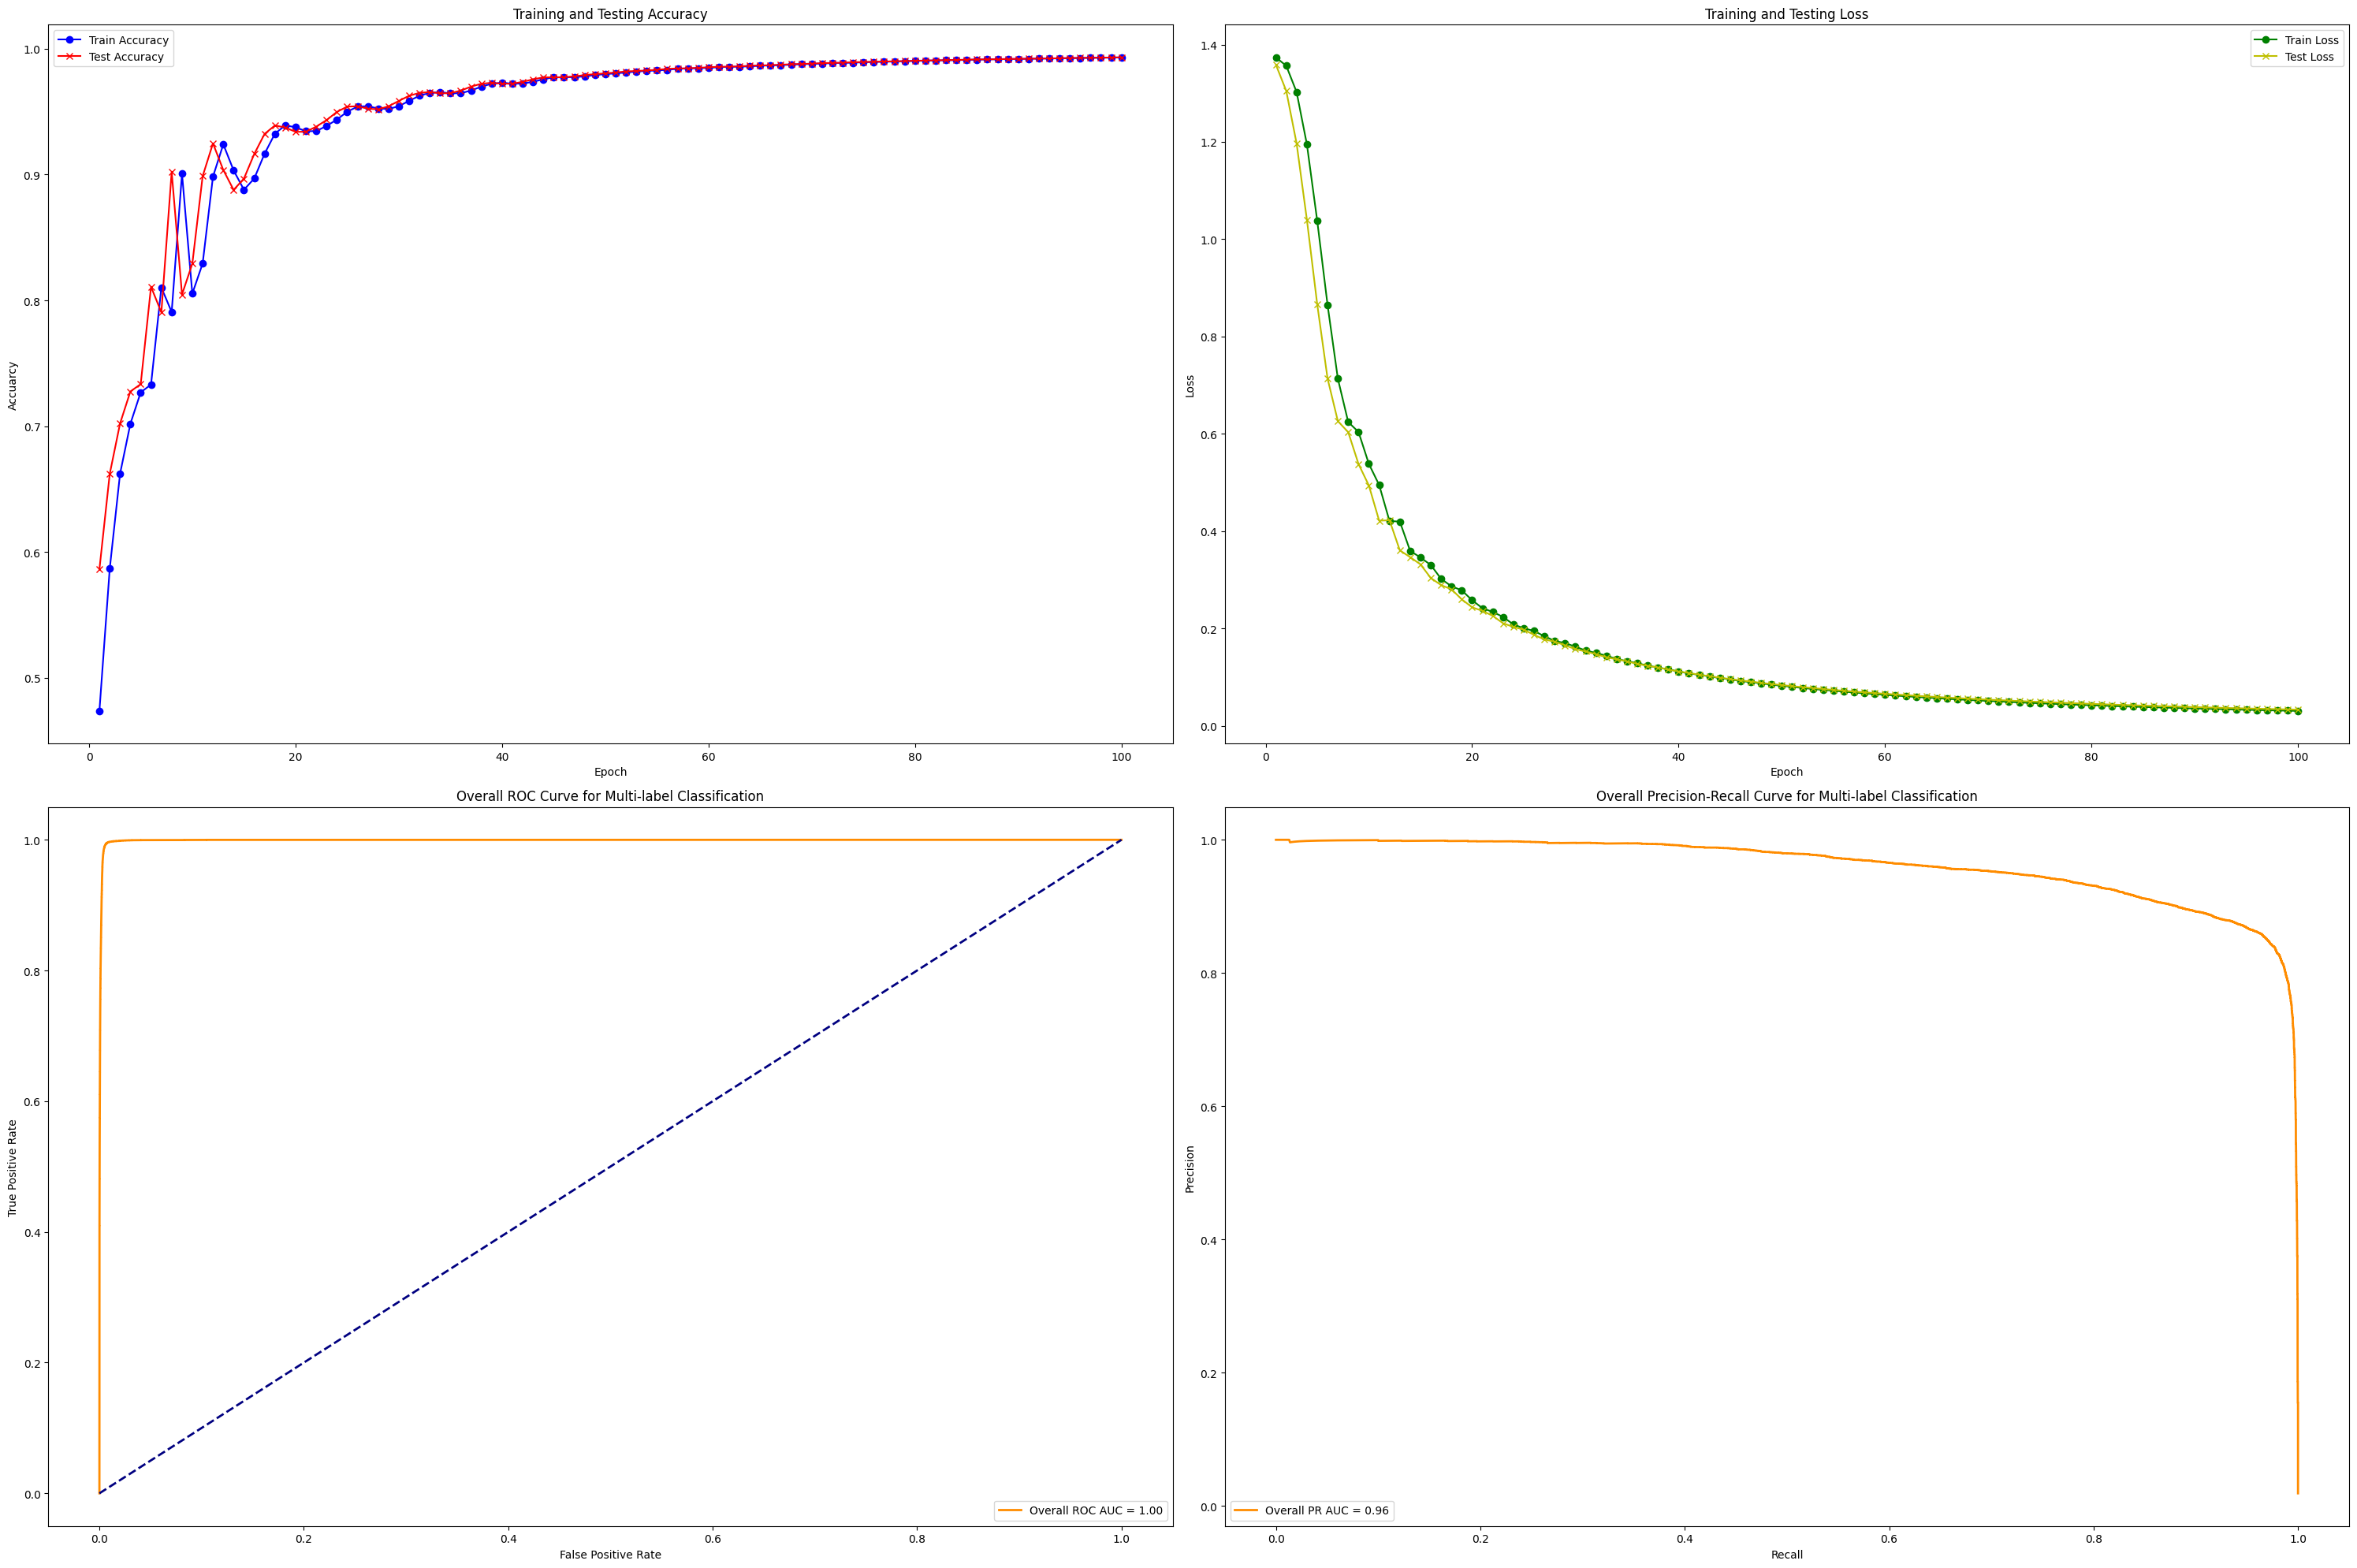

TRAIN: [    0     2     3 ... 17334 17335 17336] TEST: [    1    16    22 ... 17327 17329 17337]
Epoch 1/100, Train Loss: 1.3739, Train Accuracy: 0.5323, Test Loss: 1.3639, Test Accuracy: 0.6182
Epoch 2/100, Train Loss: 1.3590, Train Accuracy: 0.6182, Test Loss: 1.3131, Test Accuracy: 0.6884
Epoch 3/100, Train Loss: 1.3082, Train Accuracy: 0.6884, Test Loss: 1.2067, Test Accuracy: 0.7339
Epoch 4/100, Train Loss: 1.2012, Train Accuracy: 0.7335, Test Loss: 1.0529, Test Accuracy: 0.7340
Epoch 5/100, Train Loss: 1.0463, Train Accuracy: 0.7336, Test Loss: 0.8873, Test Accuracy: 0.7147
Epoch 6/100, Train Loss: 0.8817, Train Accuracy: 0.7138, Test Loss: 0.7388, Test Accuracy: 0.8234
Epoch 7/100, Train Loss: 0.7313, Train Accuracy: 0.8239, Test Loss: 0.6557, Test Accuracy: 0.7564
Epoch 8/100, Train Loss: 0.6550, Train Accuracy: 0.7558, Test Loss: 0.5926, Test Accuracy: 0.8837
Epoch 9/100, Train Loss: 0.5908, Train Accuracy: 0.8841, Test Loss: 0.5007, Test Accuracy: 0.8384
Epoch 10/100, Train L

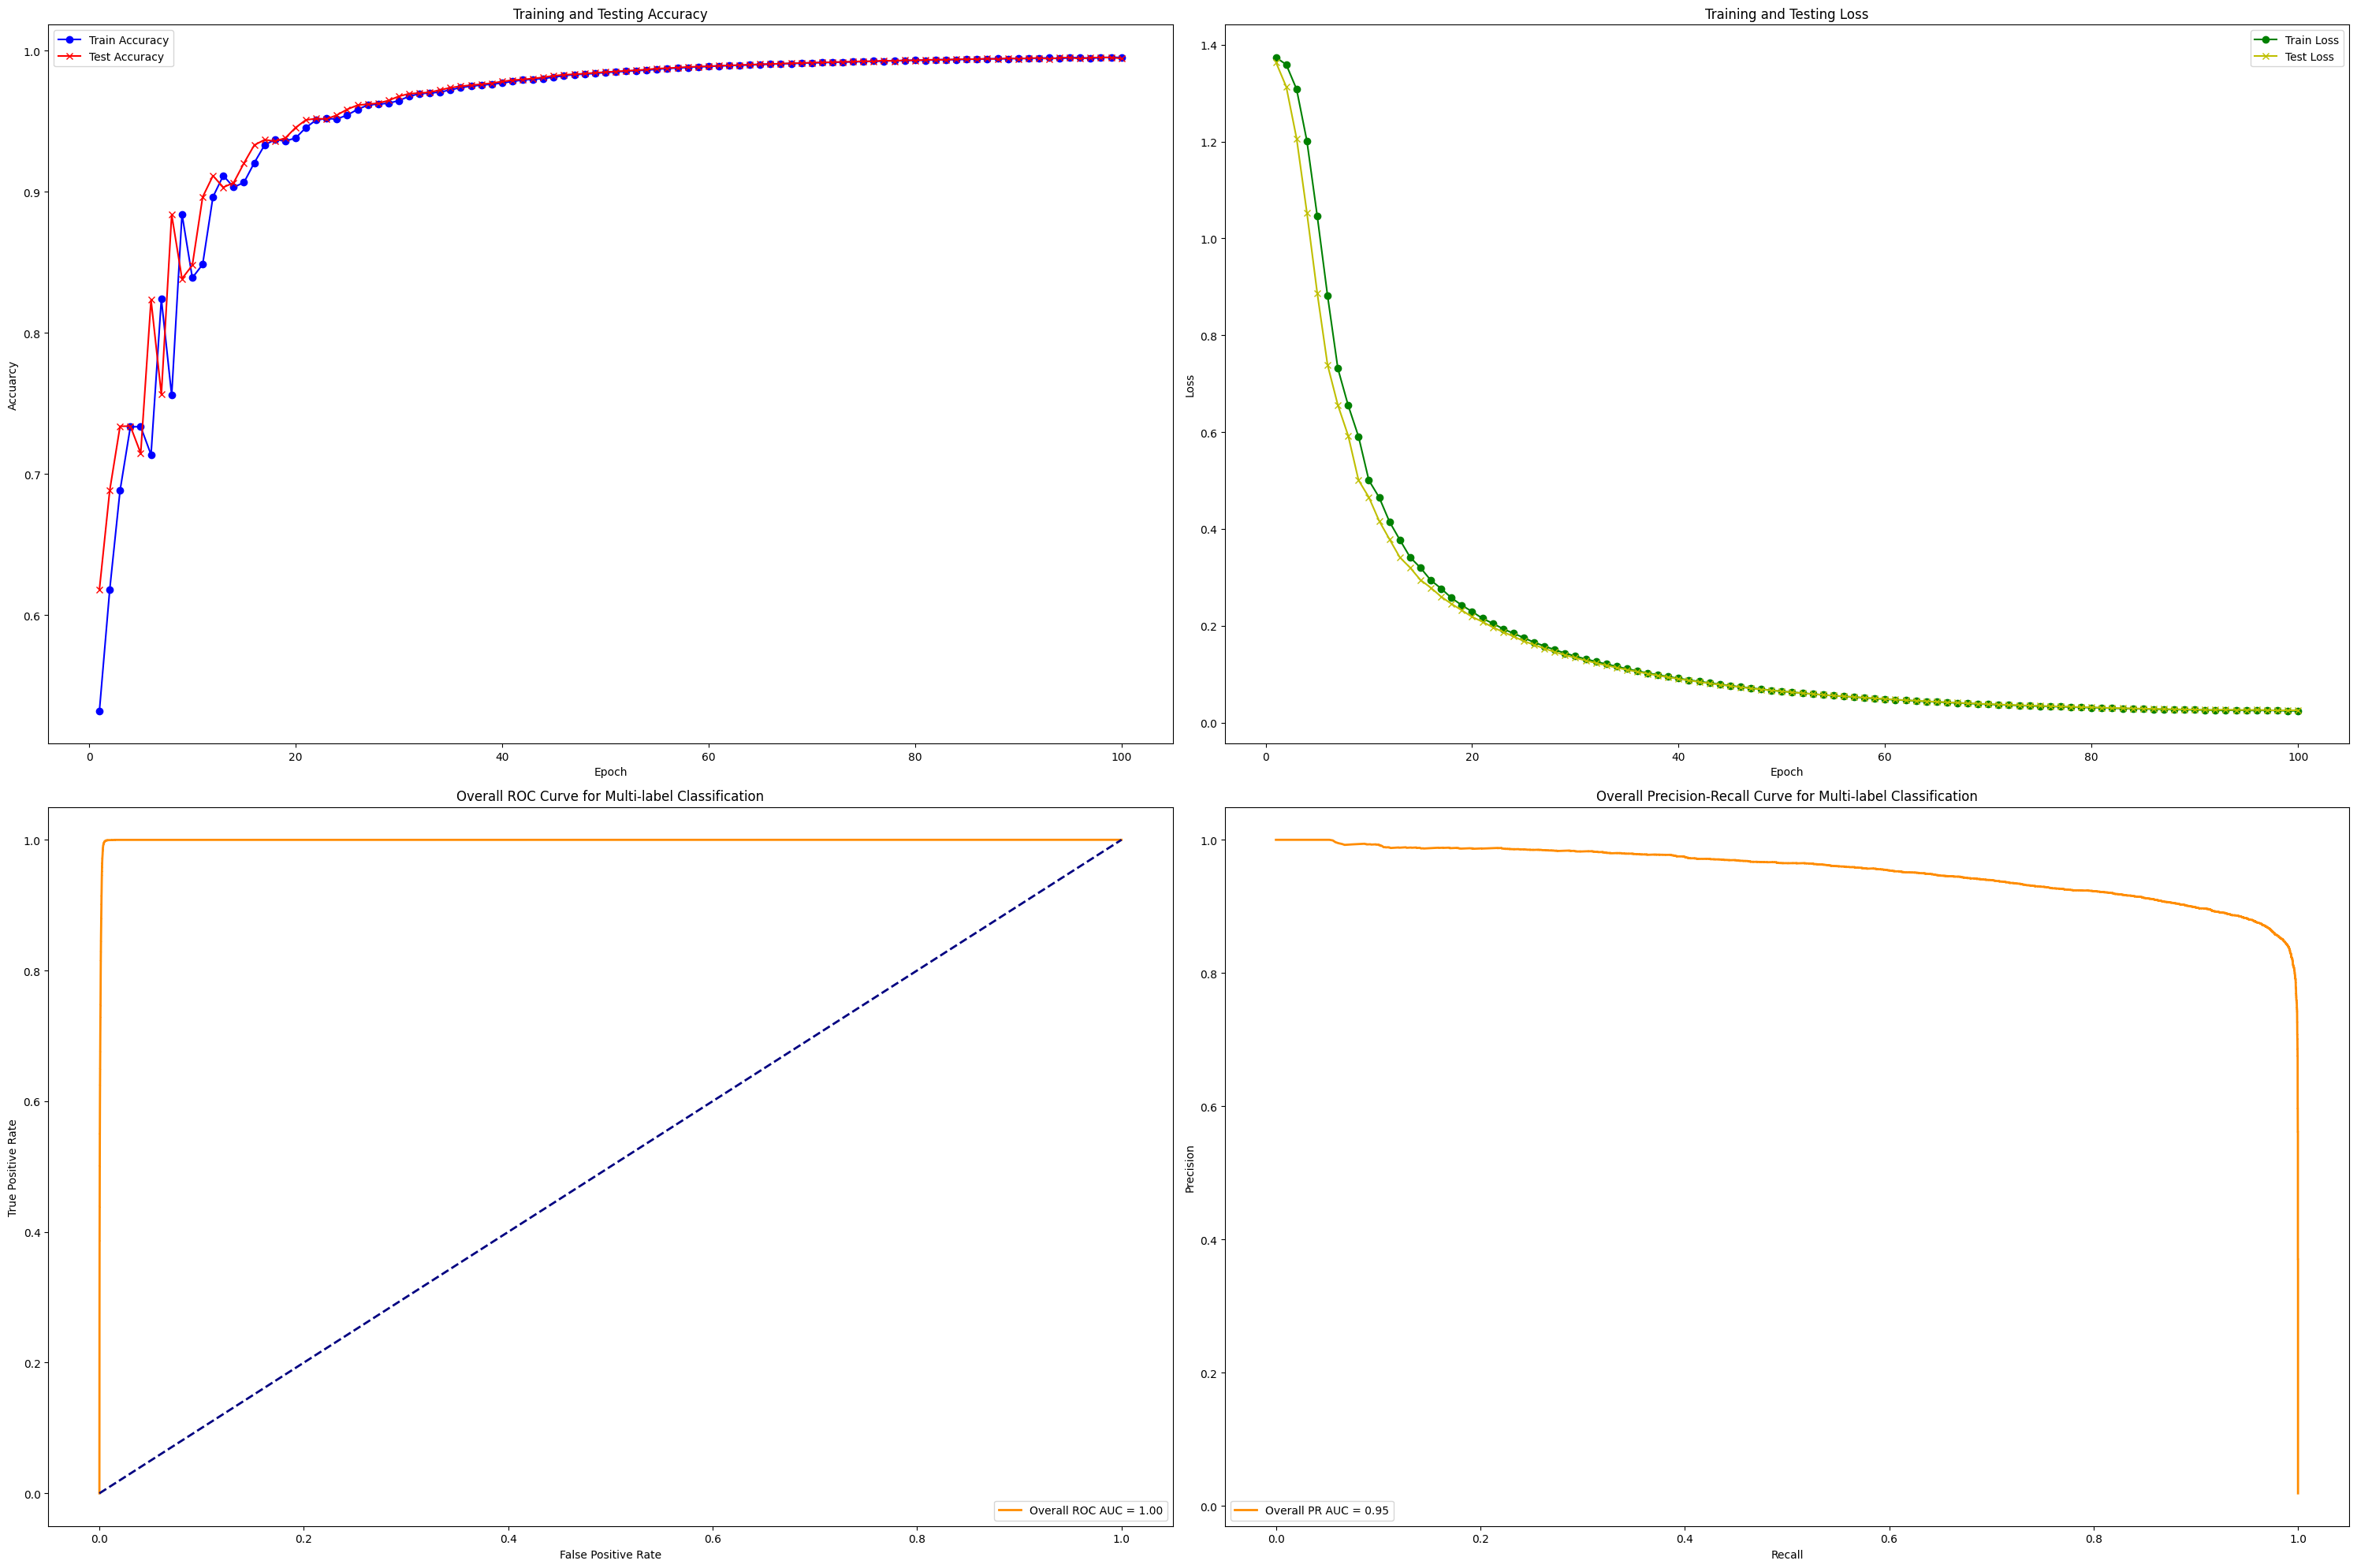

TRAIN: [    0     1     2 ... 17335 17336 17337] TEST: [   10    13    15 ... 17308 17325 17327]
Epoch 1/100, Train Loss: 1.3737, Train Accuracy: 0.4666, Test Loss: 1.3533, Test Accuracy: 0.5781
Epoch 2/100, Train Loss: 1.3571, Train Accuracy: 0.5787, Test Loss: 1.3003, Test Accuracy: 0.6498
Epoch 3/100, Train Loss: 1.3035, Train Accuracy: 0.6501, Test Loss: 1.1923, Test Accuracy: 0.6908
Epoch 4/100, Train Loss: 1.1940, Train Accuracy: 0.6900, Test Loss: 1.0396, Test Accuracy: 0.7230
Epoch 5/100, Train Loss: 1.0387, Train Accuracy: 0.7216, Test Loss: 0.8773, Test Accuracy: 0.7197
Epoch 6/100, Train Loss: 0.8768, Train Accuracy: 0.7177, Test Loss: 0.7331, Test Accuracy: 0.8089
Epoch 7/100, Train Loss: 0.7311, Train Accuracy: 0.8072, Test Loss: 0.6425, Test Accuracy: 0.7662
Epoch 8/100, Train Loss: 0.6439, Train Accuracy: 0.7652, Test Loss: 0.6296, Test Accuracy: 0.8955
Epoch 9/100, Train Loss: 0.6305, Train Accuracy: 0.8956, Test Loss: 0.5674, Test Accuracy: 0.7909
Epoch 10/100, Train L

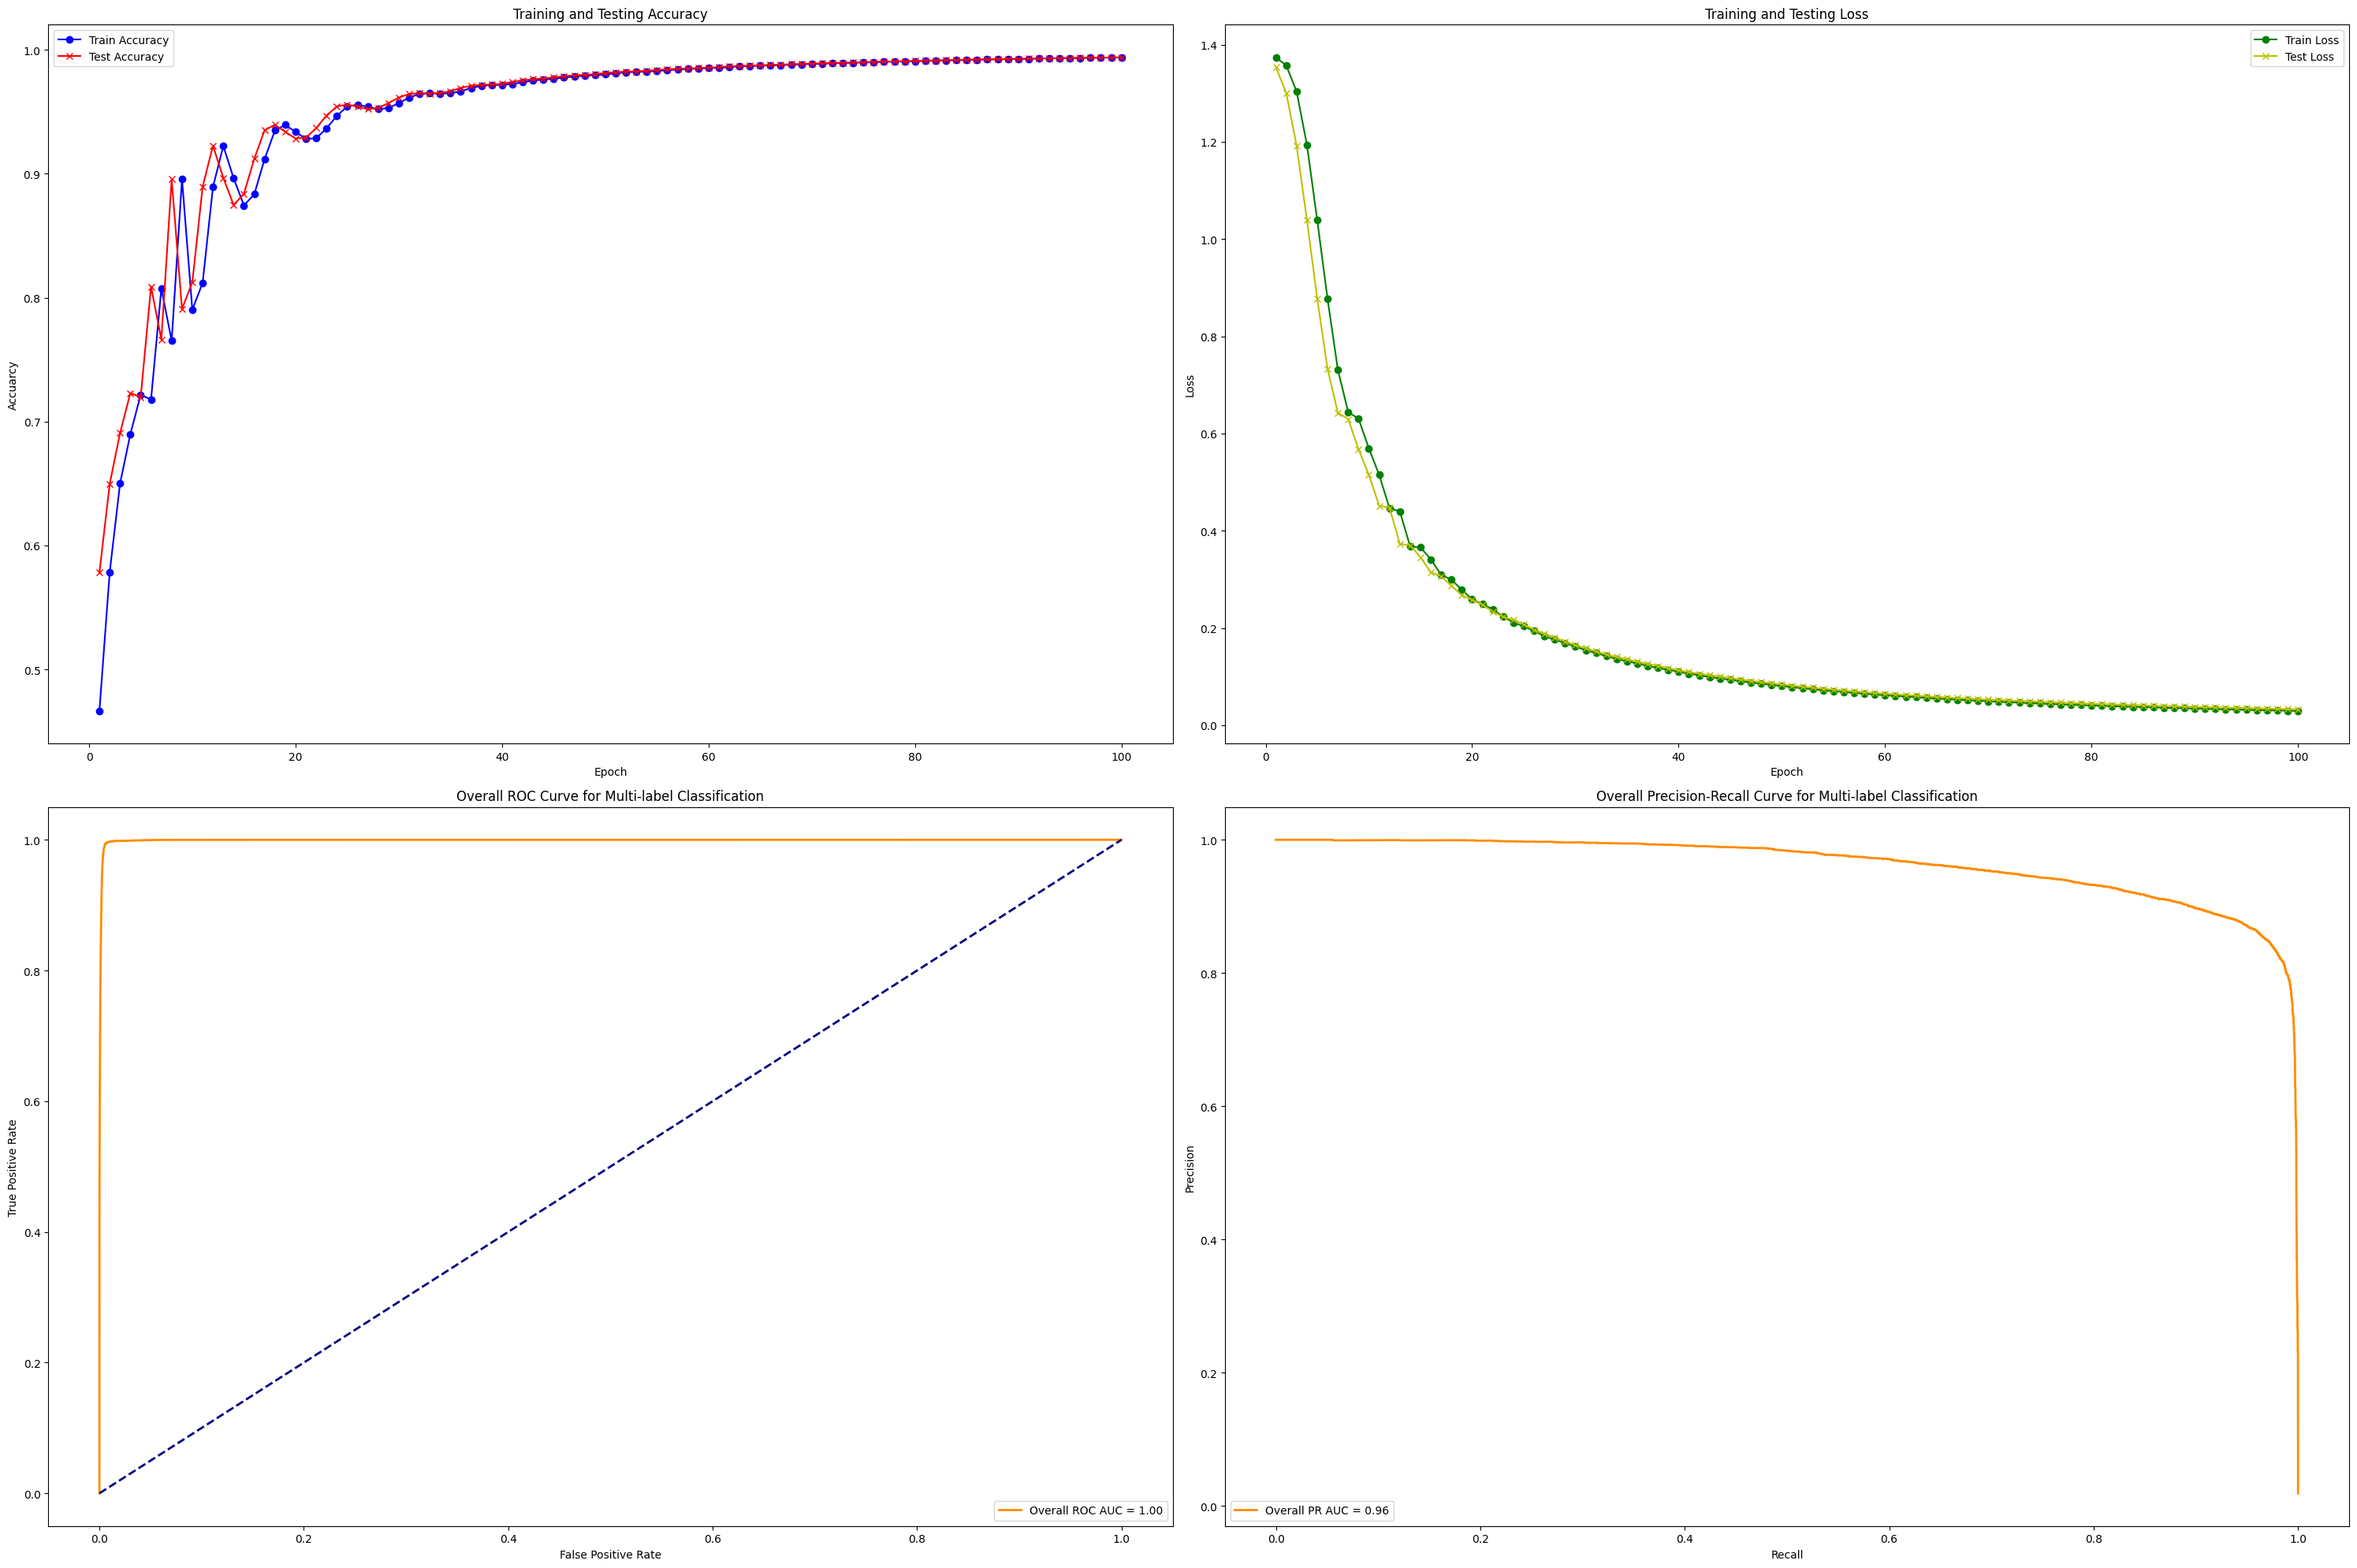

TRAIN: [    0     1     3 ... 17335 17336 17337] TEST: [    2     5     7 ... 17329 17331 17332]
Epoch 1/100, Train Loss: 1.3736, Train Accuracy: 0.5249, Test Loss: 1.3507, Test Accuracy: 0.6322
Epoch 2/100, Train Loss: 1.3555, Train Accuracy: 0.6323, Test Loss: 1.2940, Test Accuracy: 0.6683
Epoch 3/100, Train Loss: 1.2988, Train Accuracy: 0.6688, Test Loss: 1.1803, Test Accuracy: 0.7016
Epoch 4/100, Train Loss: 1.1855, Train Accuracy: 0.7019, Test Loss: 1.0204, Test Accuracy: 0.7220
Epoch 5/100, Train Loss: 1.0257, Train Accuracy: 0.7222, Test Loss: 0.8537, Test Accuracy: 0.7116
Epoch 6/100, Train Loss: 0.8574, Train Accuracy: 0.7113, Test Loss: 0.7245, Test Accuracy: 0.8355
Epoch 7/100, Train Loss: 0.7290, Train Accuracy: 0.8356, Test Loss: 0.7077, Test Accuracy: 0.7202
Epoch 8/100, Train Loss: 0.7135, Train Accuracy: 0.7185, Test Loss: 0.5754, Test Accuracy: 0.8565
Epoch 9/100, Train Loss: 0.5754, Train Accuracy: 0.8556, Test Loss: 0.5343, Test Accuracy: 0.8935
Epoch 10/100, Train L

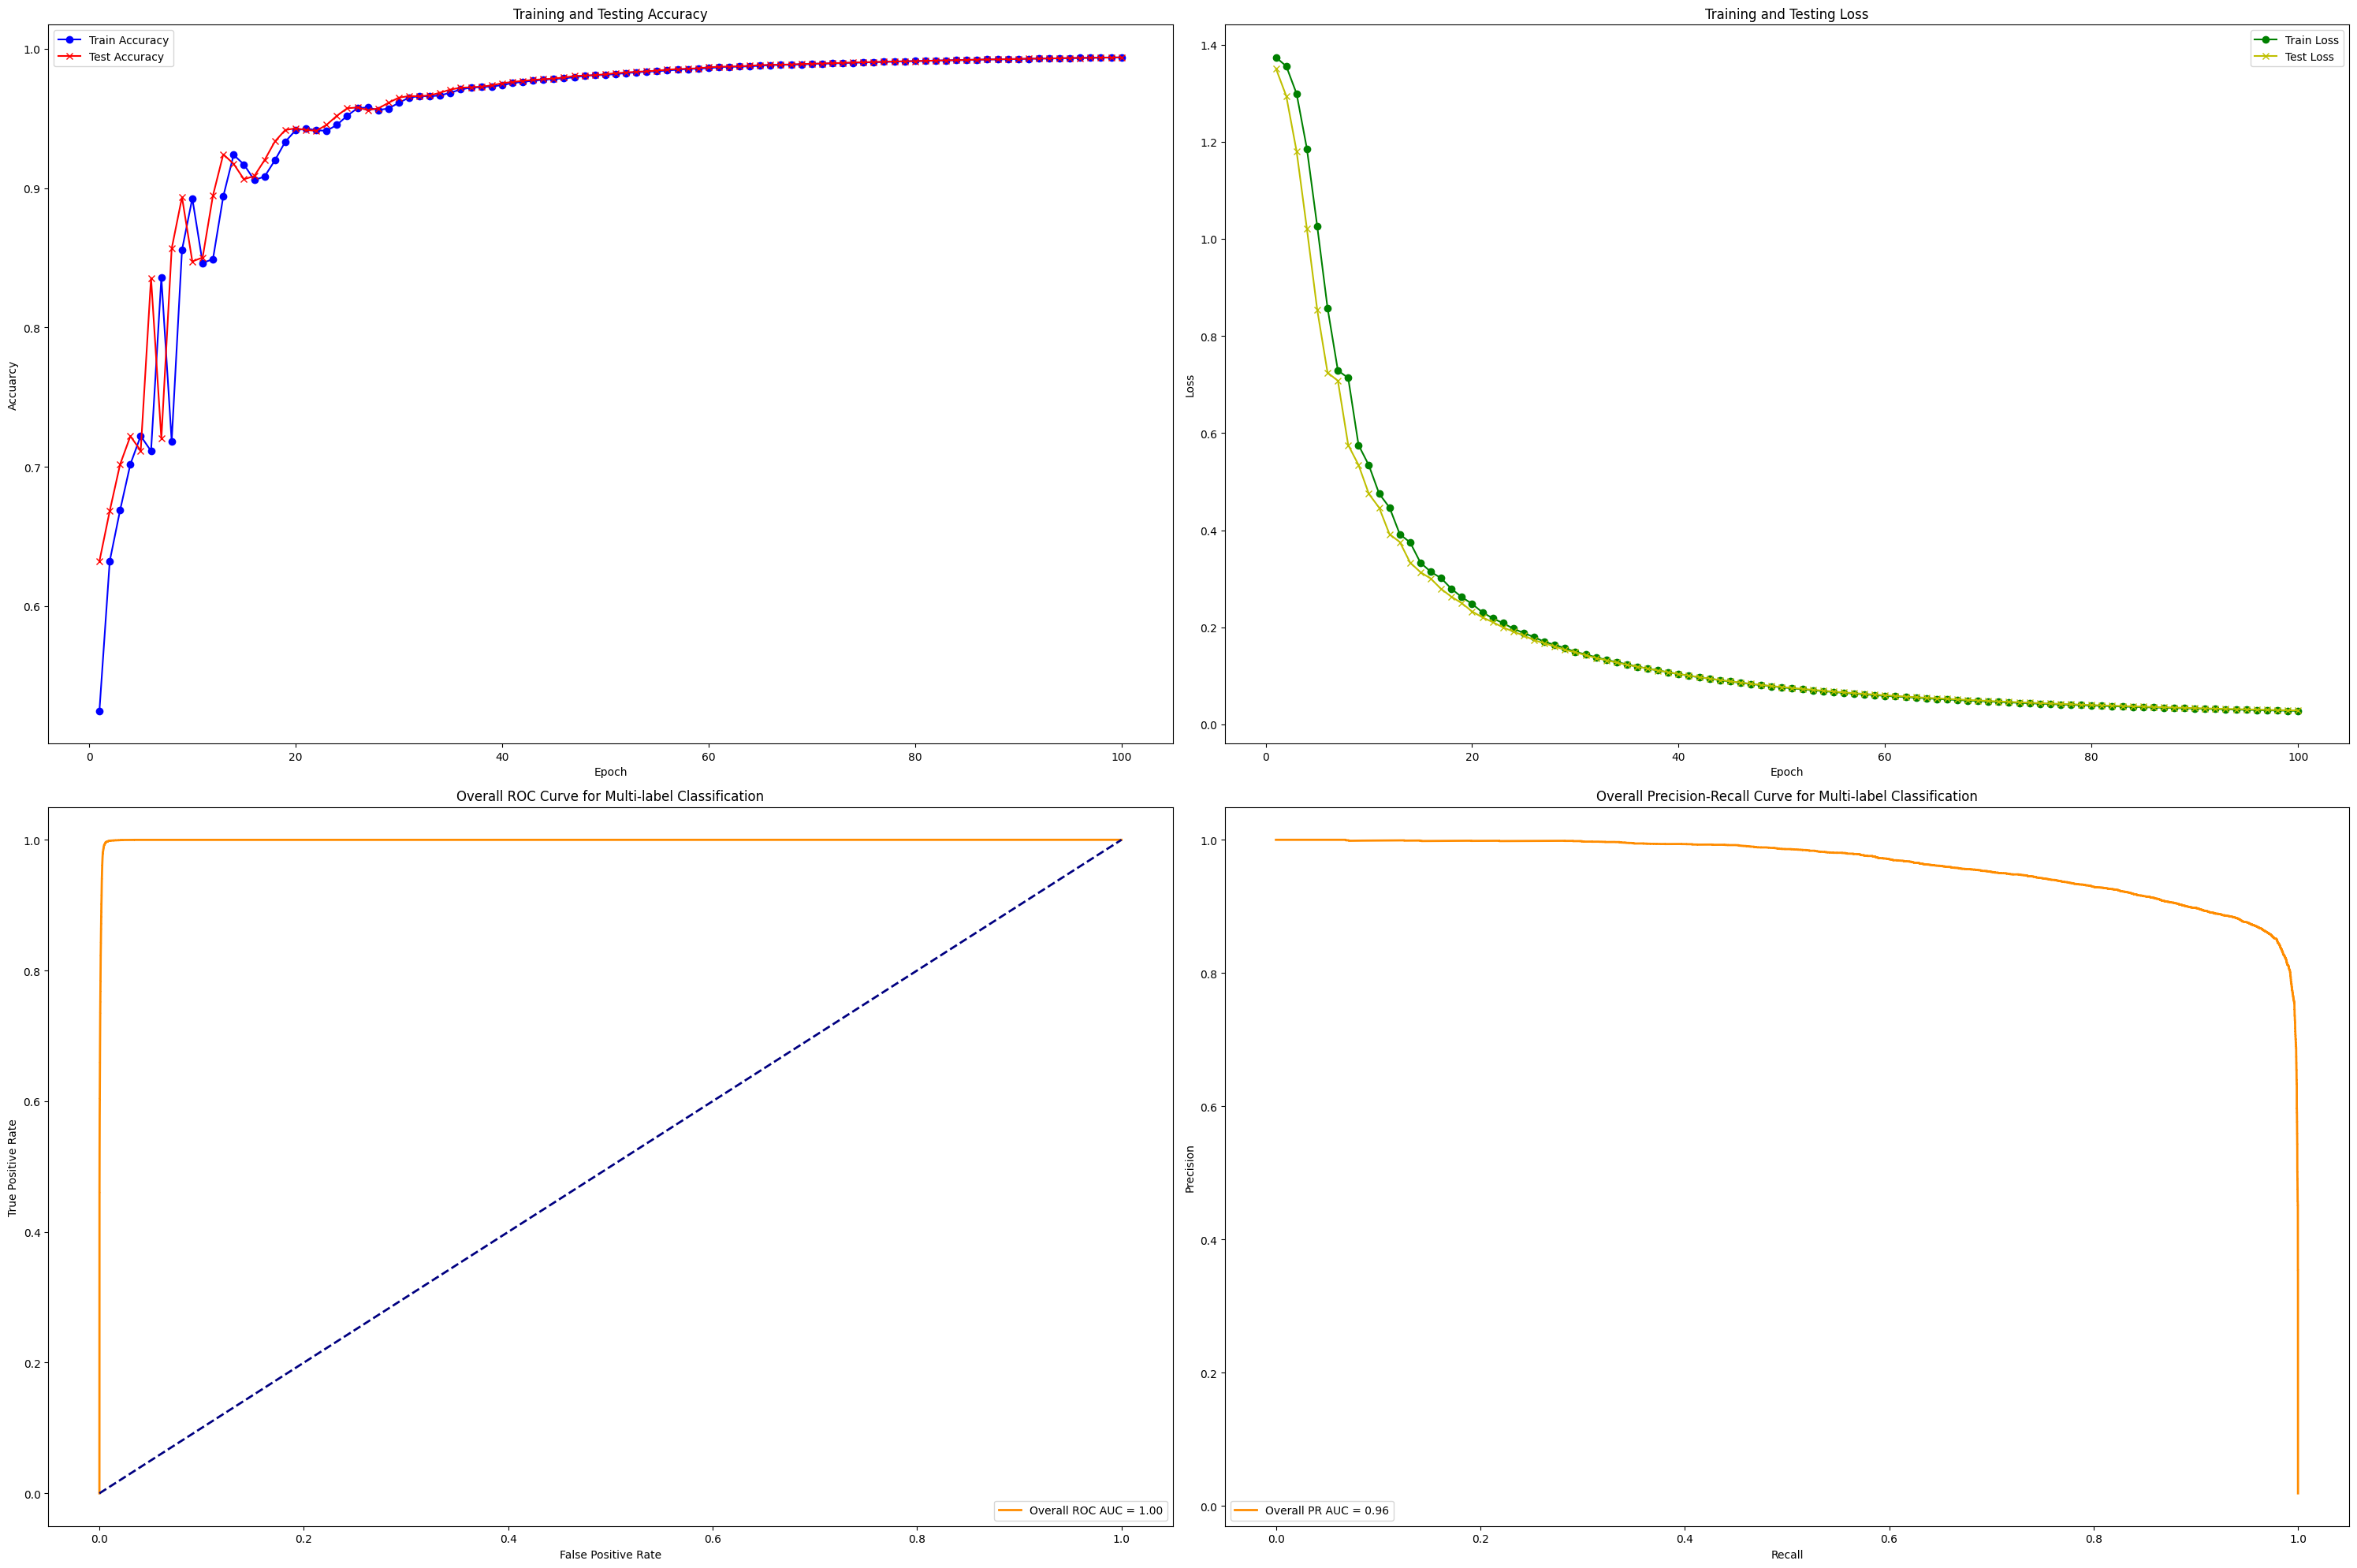

In [35]:
# input_train_splits, input_test_splits, label_train_splits, label_test_splits = [], [], [], []
from sklearn.metrics import roc_curve, auc, precision_recall_curve
for train_index, test_index in msss.split(inputs, outputs):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = inputs[train_index], inputs[test_index]
   y_train, y_test = outputs[train_index], outputs[test_index]

   train_class_counts = np.sum(y_train == 1, axis=0)
  # Sum along rows for each class
   classes = torch.arange(len(train_class_counts))  # Class indices
   class_weights = y_train.shape[0]/(train_class_counts)    # from deep fri 
   weight_tensor = torch.tensor(class_weights)
   
   model = BP_PredictorModel(225, 296)

   # Criterion and Optimizer
   criterion = nn.BCEWithLogitsLoss(pos_weight= weight_tensor)
   optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
   
   # Lists to store accuracy values for plotting
   train_accuracies = []
   test_accuracies = []
   train_losses = []
   test_losses = []

   train_label = torch.from_numpy(y_train).float()                            
   test_label = torch.from_numpy(y_test).float()

   # Training loop
   num_epochs = 100
   for epoch in range(num_epochs):
      # Train
      train_loss, train_accuracy = train_model(model, torch.from_numpy(X_train).float(), train_label, criterion, optimizer)
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Test (optional: use a separate test dataset)
      test_loss, test_accuracy = test_model(model, torch.from_numpy(X_test).float(), test_label, criterion)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)

      print(f"Epoch {epoch + 1}/{num_epochs}, "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
   
   
       # Plotting the accuracies
   fig, axes = plt.subplots(2, 2, figsize=(30, 20))  # 1 row, 2 columns
   axes[0][0].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', color='b', linestyle='-', marker='o')
   axes[0][0].plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='r', linestyle='-', marker='x')
   axes[0][0].set_title('Training and Testing Accuracy')
   axes[0][0].set_xlabel('Epoch')
   axes[0][0].set_ylabel('Accuarcy')
   axes[0][0].legend()

   axes[0][1].plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='g', linestyle='-', marker='o')
   axes[0][1].plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='y', linestyle='-', marker='x')
   axes[0][1].set_title('Training and Testing Loss')
   axes[0][1].set_xlabel('Epoch')
   axes[0][1].set_ylabel('Loss')
   axes[0][1].legend()

   true_labels = y_test.astype(int)

   model.eval()
   with torch.no_grad():
      # Forward pass to get model predictions
      output_pred = model(torch.from_numpy(X_test).float()).sigmoid().numpy()
   predicted_labels = (output_pred > 0.5).astype(int)

   y_true_flat = true_labels.ravel()
   y_pred_flat = output_pred.ravel()

   fpr_all, tpr_all, _ = roc_curve(y_true_flat, y_pred_flat)
   roc_auc_all = auc(fpr_all, tpr_all)
   axes[1][0].plot(fpr_all, tpr_all, color='darkorange', lw=2, label=f'Overall ROC AUC = {roc_auc_all:.2f}')
   axes[1][0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   axes[1][0].set_title('Overall ROC Curve for Multi-label Classification')
   axes[1][0].set_xlabel('False Positive Rate')
   axes[1][0].set_ylabel('True Positive Rate')
   axes[1][0].legend(loc="lower right")

   precision_all, recall_all, _ = precision_recall_curve(y_true_flat, y_pred_flat)
   pr_auc_all = auc(recall_all, precision_all)

   axes[1][1].plot(recall_all, precision_all, color='darkorange', lw=2, label=f'Overall PR AUC = {pr_auc_all:.2f}')
   axes[1][1].set_title('Overall Precision-Recall Curve for Multi-label Classification')
   axes[1][1].set_xlabel('Recall')
   axes[1][1].set_ylabel('Precision')
   axes[1][1].legend(loc="lower left")
   plt.tight_layout()
   plt.show()